## HW2

> using densenet with training data plus (origin data+augmentation data)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# see more data augmentation https://pytorch.org/vision/stable/transforms.html
mean = (0.5071, 0.4867, 0.4408)
std = (0.2675, 0.2565, 0.2761)
train_transform1 = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)]) 

train_transform2 = transforms.Compose(
    [transforms.RandomResizedCrop(size=32, scale=(0.08, 1.0), ratio=(0.75, 1.33), interpolation=2), 
     transforms.ToTensor(),
     transforms.Normalize(mean, std)])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean, std)]) # calculte yourself

batch_size = 64
num_classes = 100    # check

trainset1 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform1)
trainset2 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform2)

trainloader = torch.utils.data.DataLoader(trainset1+trainset2, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:853: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# pick one

# 1. model defined by yourself
# model = my_CNN()        
   
# 2. off-the-shelf model
# see https://pytorch.org/vision/stable/models.html
# nn.Linear https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
model = models.densenet201(pretrained=True) 
# model.classifier = torch.nn.Linear(1024, num_classes)
# model.classifier = torch.nn.Linear(2208, num_classes)
# model.classifier = torch.nn.Linear(1664, num_classes)
model.classifier = torch.nn.Linear(1920, num_classes)
model.features.conv0 = nn.Conv2d(3,64,kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
model.features.pool0 = nn.Identity()

model.to(device)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): Identity()
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 128, kernel_s

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)

In [ ]:
total_epoch = 200
print_per_iteration = 100
# save_path = '/content/drive/MyDrive/Colab Notebooks/ML_HW2/myCNN_test/modify_DenseNet121_.pth'
acc_list = []
max_acc = (0,0)

for epoch in range(total_epoch):  # loop over the dataset multiple times
    model.train()
    save_path = '/content/drive/MyDrive/Colab Notebooks/ML_HW2/myCNN_test/bigData1_DenseNet201.pth'
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(inputs)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        # if (i+1) % print_per_iteration == 0:    # print every 2000 mini-batches
        #     print(f'[ep {epoch + 1}][{i + 1:5d}/{len(trainloader):5d}] loss: {loss.item():.3f}')
    # torch.save(model, save_path)

    correct = 0
    total = 0
    model.eval()
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            n_acc = correct/total
    print(f'Accuracy of epoch {epoch+1} : {100 * correct / total:.2f} %')
    acc_list.append(n_acc)
      
    if n_acc > max_acc[0] :
      max_acc = (n_acc,epoch)
      torch.save(model, save_path)

Accuracy of epoch 1 : 17.59 %
Accuracy of epoch 2 : 34.29 %
Accuracy of epoch 3 : 46.97 %
Accuracy of epoch 4 : 54.72 %
Accuracy of epoch 5 : 59.82 %
Accuracy of epoch 6 : 64.22 %
Accuracy of epoch 7 : 67.47 %
Accuracy of epoch 8 : 69.84 %
Accuracy of epoch 9 : 71.93 %
Accuracy of epoch 10 : 73.07 %
Accuracy of epoch 11 : 74.30 %
Accuracy of epoch 12 : 75.08 %
Accuracy of epoch 13 : 76.14 %
Accuracy of epoch 14 : 76.72 %
Accuracy of epoch 15 : 77.37 %
Accuracy of epoch 16 : 77.92 %
Accuracy of epoch 17 : 78.38 %
Accuracy of epoch 18 : 78.79 %
Accuracy of epoch 19 : 78.91 %
Accuracy of epoch 20 : 79.24 %
Accuracy of epoch 21 : 79.60 %
Accuracy of epoch 22 : 79.89 %
Accuracy of epoch 23 : 80.09 %
Accuracy of epoch 24 : 80.16 %
Accuracy of epoch 25 : 80.41 %
Accuracy of epoch 26 : 80.62 %
Accuracy of epoch 27 : 80.78 %
Accuracy of epoch 28 : 80.87 %
Accuracy of epoch 29 : 81.07 %
Accuracy of epoch 30 : 80.97 %
Accuracy of epoch 31 : 81.06 %
Accuracy of epoch 32 : 81.27 %
Accuracy of epoch

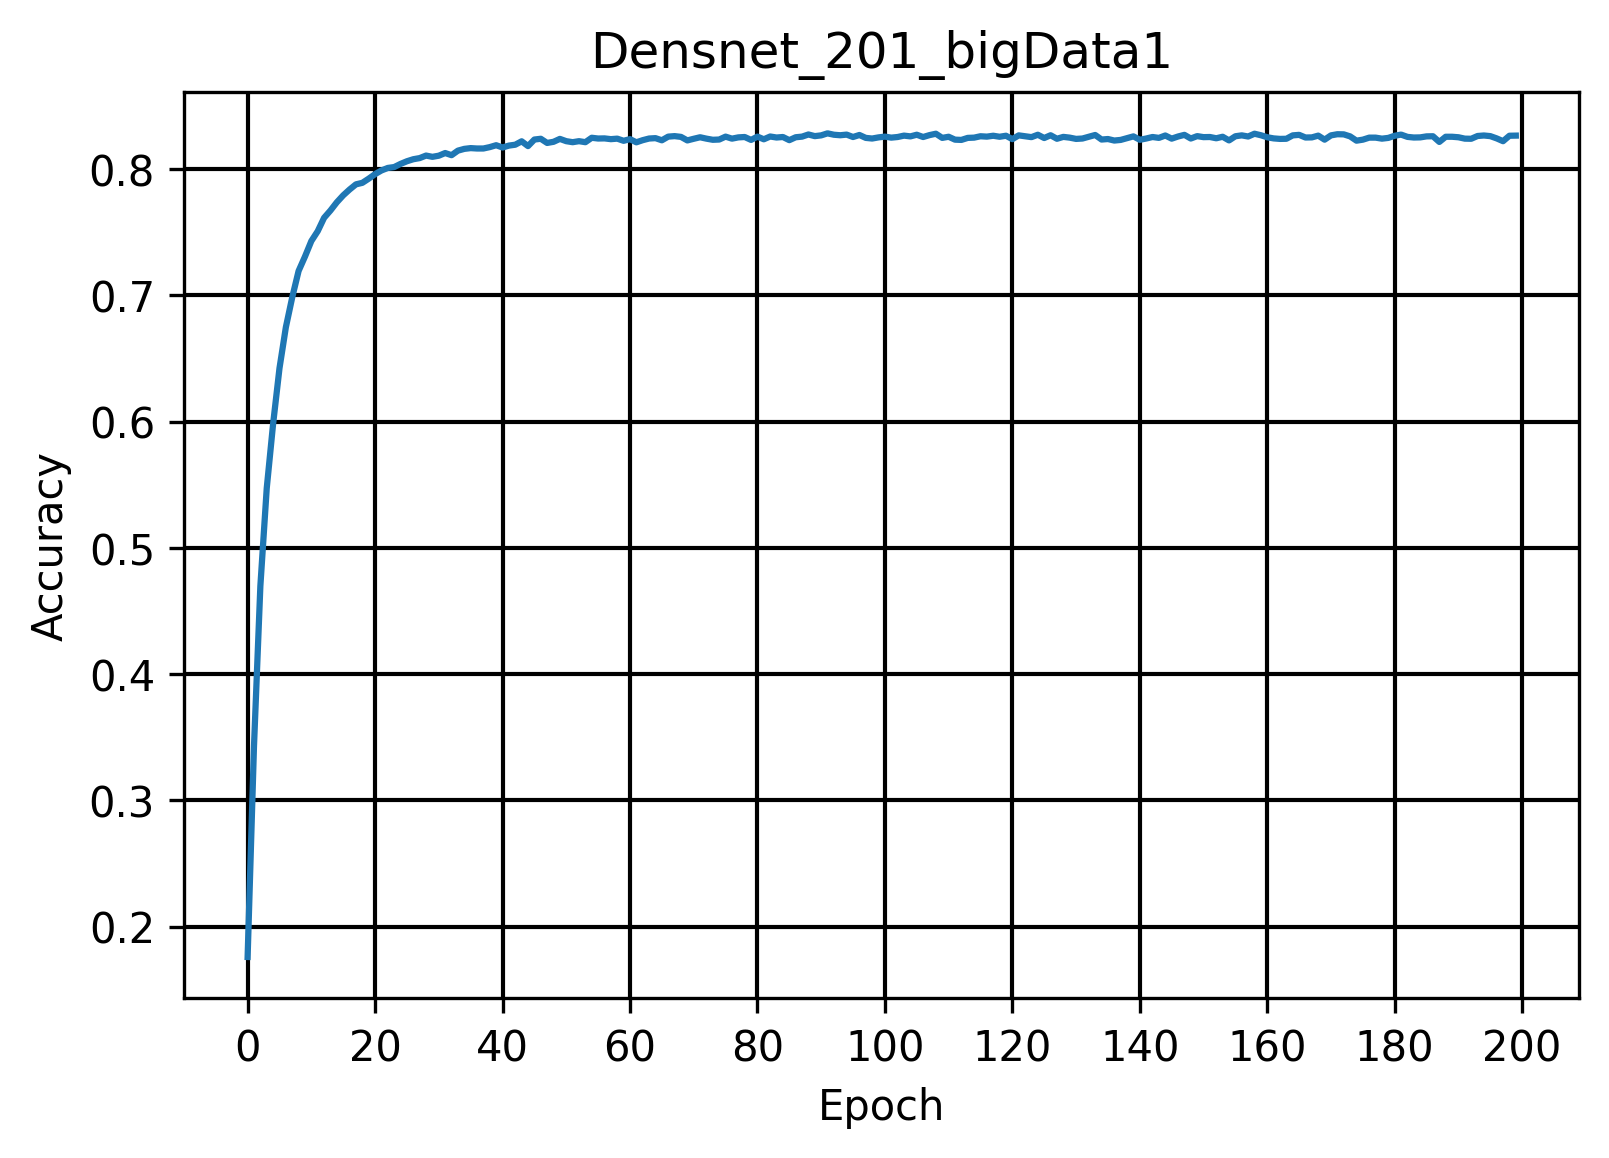

(0.8283, 91)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = range(0,200,1)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
plt.plot(x,acc_list)
plt.xticks(np.arange(0,220,step=20))
plt.title('Densnet_201_bigData1')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(color='black', linestyle='-', linewidth='1')
plt.show()

print(max_acc)